In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import stats
from scipy.stats import shapiro, levene, f_oneway, kruskal, mannwhitneyu
from scipy.stats import f_oneway
from itertools import combinations
import seaborn as sns
from factor_analyzer import FactorAnalyzer
import glob
import pingouin as pg
from scipy.stats import ttest_ind 


In [12]:
def testing_for_assumptions_by_group(df, score_col="IEQ Score", group_col="Group"):
    print(f"# Testing assumptions for {score_col} #\n")

    groups = df[group_col].unique()
    group_data = {g: df[df[group_col] == g][score_col].dropna() for g in groups}

    # 1. Shapiro–Wilk Test for Normality
    print("## Shapiro–Wilk Test for Normality ##")
    normality = {}
    for group, data in group_data.items():
        print(f"Group {group}:")
        if len(data) < 3:
            print(f"  ⚠️ Not enough data (n={len(data)}) to test normality.\n")
            normality[group] = False
            continue
        stat, p = shapiro(data)
        normal = p > 0.05
        normality[group] = normal
        if normal:
            print(f"  ✔️ Stat = {stat:.4f}, p = {p:.4f} → Data appears normal\n")
        else:
            print(f"  ❌ Stat = {stat:.4f}, p = {p:.4f} → Data not normal\n")

    print("## Levene’s Test for Equal Variances ##")
    data_lists = [d for d in group_data.values() if len(d) >= 2]
    if len(data_lists) >= 2:
        stat, p = levene(*data_lists)
        equal_var = p > 0.05
        if equal_var:
            print(f"  ✔️ Stat = {stat:.4f}, p = {p:.4f} → Variances are equal\n")
        else:
            print(f"  ❌ Stat = {stat:.4f}, p = {p:.4f} → Variances are not equal\n")
    else:
        equal_var = False
        print("  ⚠️ Not enough groups with sufficient data to test variance\n")

    print(f"# Final Group Comparison Test for {score_col} #")
    normal_all = all(normality.values())
    sufficient_groups = len([group_data[g] for g in groups if len(group_data[g]) >= 2]) > 2
    if normal_all and equal_var:
        print("✅ All assumptions met. Running ANOVA:")
        if(sufficient_groups):
            stat, p = f_oneway(*[group_data[g] for g in groups if len(group_data[g]) >= 2])
            print(f"  ✔️ ANOVA Stat = {stat:.4f}, p = {p:.4f}")
        return 1
    else:
        print("❌ Assumptions not met. Using non-parametric Kruskal–Wallis:")
        if(sufficient_groups):
            stat, p = kruskal(*[group_data[g] for g in groups if len(group_data[g]) >= 2])
            print(f"  ✔️ Kruskal–Wallis Stat = {stat:.4f}, p = {p:.4f}")
        return 0


In [13]:
def analyze_groups_anova(df, score_col, group_col):
    # Extract data for each group
    groups = df[group_col].unique()
    group_data = [df[df[group_col] == group][score_col].dropna() for group in groups]
    
    # Combine all groups into one dataset
    all_data = pd.concat(group_data)
    grand_mean = all_data.mean()

    # Calculate Sum of Squares Between (SS_between)
    SS_between = sum(len(group) * (group.mean() - grand_mean)**2 for group in group_data)

    # Calculate Sum of Squares Within (SS_within)
    SS_within = sum(sum((group - group.mean())**2) for group in group_data)

    # Calculate Total Sum of Squares (SS_total)
    SS_total = SS_between + SS_within

    # Calculate Eta Squared (η²)
    eta_squared = SS_between / SS_total

    # Perform one-way ANOVA
    stat, p = f_oneway(*group_data)

    # Print results
    print("SS stands for Sum of Squares")
    print(f"SS_between: {SS_between:.4f}")
    print(f"SS_within: {SS_within:.4f}")
    print(f"SS_total: {SS_total:.4f}")
    print(f"Effect Size (Eta Squared, η²): {eta_squared:.4f}")
    print(f"ANOVA Results: F-statistic = {stat:.4f}, p-value = {p:.4f}")
    if p < 0.05:
        print("There is a significant difference between the groups.")
    else:
        print("No significant difference between the groups.")

    # Plot the scores for each group
    plt.figure(figsize=(8, 6))
    boxplot = plt.boxplot(group_data, labels=groups, patch_artist=True, showmeans=True)
    plt.title(f"{score_col} by {group_col}")

    # Assign different colors to each group
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for box, color in zip(boxplot['boxes'], colors):
        box.set_facecolor(color)

    plt.ylabel(score_col)
    plt.xlabel(group_col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Return results as a dictionary
    return {
        "SS_between": SS_between,
        "SS_within": SS_within,
        "SS_total": SS_total,
        "eta_squared": eta_squared,
        "anova_stat": stat,
        "anova_p_value": p
    }

In [14]:
def analyze_kruskal_test(df, score_col, group_col):
    groups = df[group_col].unique()
    group_data = [df[df[group_col] == group][score_col].dropna() for group in groups]
    stat, p = kruskal(*group_data)
    print(f"Kruskal-Wallis test statistic = {stat:.4f}, p-value = {p:.4f}")
    if p < 0.05:
        print("There is a significant difference between the groups.")
    else:
        print("No significant difference between the groups.")
    plt.figure(figsize=(8, 6))
    boxplot = plt.boxplot(group_data, labels=groups, patch_artist=True, showmeans=True)
    plt.title(f"{score_col} by {group_col} (Kruskal-Wallis Test)")
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for box, color in zip(boxplot['boxes'], colors):
        box.set_facecolor(color)

    plt.ylabel(score_col)
    plt.xlabel(group_col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Return results as a dictionary
    return {
        "kruskal_stat": stat,
        "kruskal_p_value": p
    }

In [20]:
# Define the folder containing the CSV files
data_folder = "Data"

# Initialize an empty list to store individual DataFrames
dataframes = []

# Iterate through all CSV files in the folder
for file_path in glob.glob(os.path.join(data_folder, "*.csv")):
    # Extract the file name without the folder path
    file_name = os.path.basename(file_path)
    
    # Extract participant type (text before .csv) and participant number (the only number in the file name)
    participant_type = file_name.split('_')[-1].split('.')[0]
    participant_number = ''.join(filter(str.isdigit, file_name))
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path, sep=';')
    
    # Add columns for participant type and participant number
    df['Group'] = participant_type
    df['Participant_id'] = participant_number
    
    # Append the DataFrame to the list
    dataframes.append(df)

print(f"Number of CSV files processed: {len(dataframes)}")
# Concatenate all DataFrames into one
metrics_pd = pd.concat(dataframes, ignore_index=True)
metrics_pd
# Convert the first three columns (Score, Time, Distance) from strings to floats
for col in ['Score', 'Time', 'Distance']:
    metrics_pd[col] = metrics_pd[col].str.replace(',', '.').astype(float)

# Display the updated DataFrame
metrics_pd

Number of CSV files processed: 8


,Score,Time,Distance,Group,Participant_id
0,1.370292,3.855138,0.612954,HandTracking,1
1,3.558710,2.599468,0.828235,HandTracking,1
2,1.815565,3.418312,0.898541,HandTracking,1
3,1.899598,3.761827,0.384499,HandTracking,1
4,2.671717,3.397790,0.355135,HandTracking,1
...,...,...,...,...,...
75,2.542461,2.483714,1.660074,Mouse,4
76,3.468806,2.158050,1.476729,Mouse,4
77,3.252612,2.616411,1.009711,Mouse,4
78,1.216238,4.058530,0.444468,Mouse,4


In [21]:
print(metrics_pd.columns)
results = []
for col in metrics_pd.columns:
    print(f"\n\n\n### Testing for {col} ### \n")
    if col == "Group" or col == "Participant_id":
        continue
    result = testing_for_assumptions_by_group(metrics_pd, score_col=col, group_col="Group")
    results.append({"Metric": col, "Assumptions_Met": bool(result)})

# Convert the results into a DataFrame for summary
summary_df = pd.DataFrame(results)
summary_df

Index(['Score', 'Time', 'Distance', 'Group', 'Participant_id'], dtype='object')



### Testing for Score ### 

# Testing assumptions for Score #

## Shapiro–Wilk Test for Normality ##
Group HandTracking:
  ✔️ Stat = 0.9825, p = 0.7796 → Data appears normal

Group Mouse:
  ✔️ Stat = 0.9777, p = 0.6039 → Data appears normal

## Levene’s Test for Equal Variances ##
  ✔️ Stat = 0.5469, p = 0.4618 → Variances are equal

# Final Group Comparison Test for Score #
✅ All assumptions met. Running ANOVA:



### Testing for Time ### 

# Testing assumptions for Time #

## Shapiro–Wilk Test for Normality ##
Group HandTracking:
  ✔️ Stat = 0.9856, p = 0.8819 → Data appears normal

Group Mouse:
  ✔️ Stat = 0.9774, p = 0.5952 → Data appears normal

## Levene’s Test for Equal Variances ##
  ✔️ Stat = 0.3045, p = 0.5826 → Variances are equal

# Final Group Comparison Test for Time #
✅ All assumptions met. Running ANOVA:



### Testing for Distance ### 

# Testing assumptions for Distance #

## Shapiro–Wi

,Metric,Assumptions_Met
0,Score,True
1,Time,True
2,Distance,False


SS stands for Sum of Squares
SS_between: 0.2972
SS_within: 129.6139
SS_total: 129.9111
Effect Size (Eta Squared, η²): 0.0023
ANOVA Results: F-statistic = 0.1789, p-value = 0.6735
No significant difference between the groups.


C:\Users\Christian\AppData\Local\Temp\ipykernel_17788\1182566836.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(group_data, labels=groups, patch_artist=True, showmeans=True)


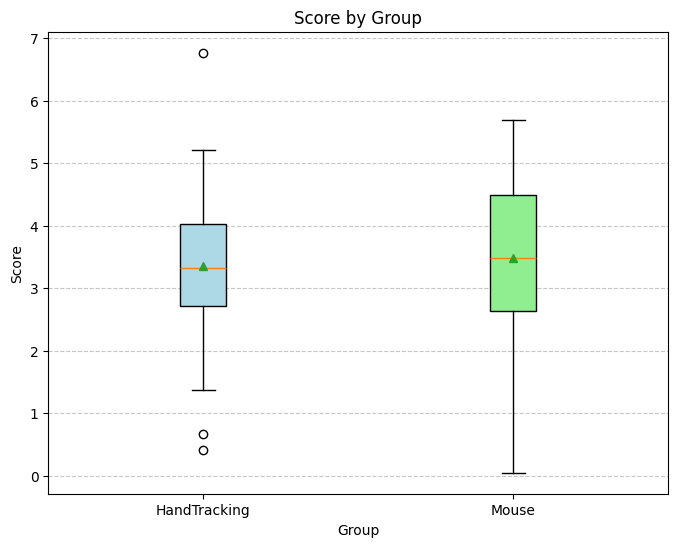

SS stands for Sum of Squares
SS_between: 0.5050
SS_within: 44.8475
SS_total: 45.3525
Effect Size (Eta Squared, η²): 0.0111
ANOVA Results: F-statistic = 0.8784, p-value = 0.3515
No significant difference between the groups.


C:\Users\Christian\AppData\Local\Temp\ipykernel_17788\1182566836.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(group_data, labels=groups, patch_artist=True, showmeans=True)


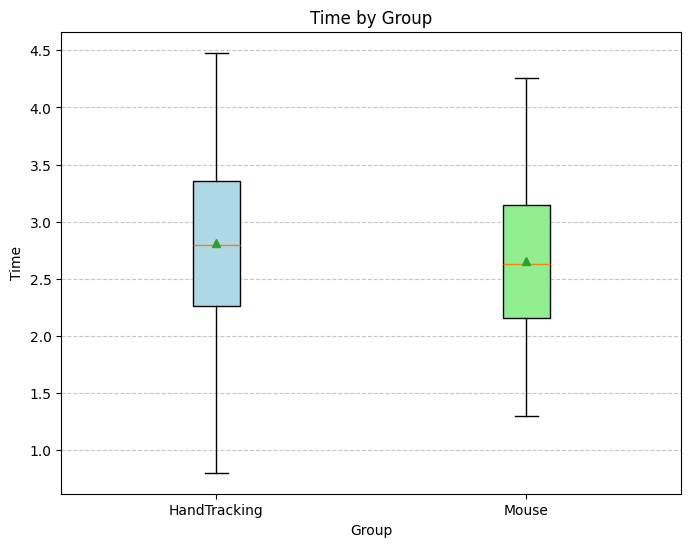

Kruskal-Wallis test statistic = 2.8681, p-value = 0.0903
No significant difference between the groups.


C:\Users\Christian\AppData\Local\Temp\ipykernel_17788\23711797.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(group_data, labels=groups, patch_artist=True, showmeans=True)


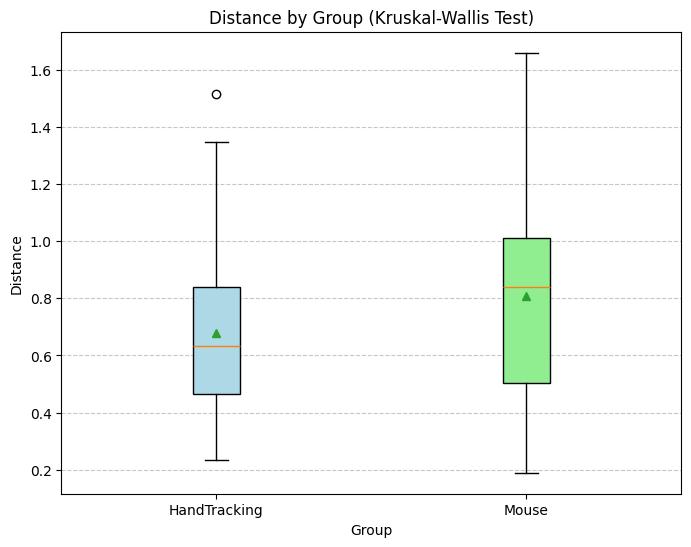

In [25]:
score_test = analyze_groups_anova(metrics_pd, score_col="Score", group_col="Group")
time_test = analyze_groups_anova(metrics_pd, score_col="Time", group_col="Group")
distance_test = analyze_kruskal_test(metrics_pd, score_col="Distance", group_col="Group")

group_stats = metrics_pd.groupby("Group").agg({
    "Score": ["mean", "std", "max", "min"],
    "Time": ["mean", "std", "max", "min"],
    "Distance": ["mean", "std", "max", "min"]
}).reset_index()

# Flatten the MultiIndex columns
group_stats.columns = ['Group', 'Score_mean', 'Score_std', 'Score_max', 'Score_min',
                       'Time_mean', 'Time_std', 'Time_max', 'Time_min',
                       'Distance_mean', 'Distance_std', 'Distance_max', 'Distance_min']

summary_results = pd.DataFrame({
    "Metric": ["Score", "Time", "Distance"],
    "Test Used": ["ANOVA", "ANOVA", "Kruskal-Wallis"],
    "p-value": [score_test["anova_p_value"], time_test["anova_p_value"], distance_test["kruskal_p_value"]],
    "Significant": [
        score_test["anova_p_value"] < 0.05,
        time_test["anova_p_value"] < 0.05,
        distance_test["kruskal_p_value"] < 0.05
    ]
})



In [26]:
group_stats

,Group,Score_mean,Score_std,Score_max,Score_min,Time_mean,Time_std,Time_max,Time_min,Distance_mean,Distance_std,Distance_max,Distance_min
0,HandTracking,3.356536,1.235855,6.767204,0.414382,2.813910,0.736146,4.479042,0.804343,0.677096,0.295155,1.515531,0.234309
1,Mouse,3.478444,1.340185,5.694653,0.045616,2.655003,0.779759,4.257937,1.299600,0.807700,0.361265,1.660074,0.189444


In [27]:
summary_results

,Metric,Test Used,p-value,Significant
0,Score,ANOVA,0.673511,False
1,Time,ANOVA,0.351543,False
2,Distance,Kruskal-Wallis,0.090349,False
